# In Depth Look at Model Training

## Solving for best Linear Regression parameters directly

Can solve linear regression directly with a closed-form solution:
Given the linear regression model
\begin{equation}
\hat{y} = h_{\mathbf{\theta}}(\mathbf{x}) = \mathbf{\theta}\cdot\mathbf{x}
\end{equation}
and cost function
\begin{equation}
\text{MSE}(\mathbf{X},h_{\mathbf{\theta}}) = \frac{1}{m}\sum_{i=1}^{m}(\mathbf{\theta}^{T}\mathbf{x}^{(i)} - y^{(i)})^{2}
\end{equation}
The set of parameters that minimize the cost function is given by the Normal Equation
\begin{equation}
\hat{\mathbf{\theta}} = (\mathbf{X^{T}X})^{-1} \mathbf{X^{T} y}
\end{equation}


Solving this equation directly on some linear-looking data:

In [1]:
import numpy as np
X = 2 * np.random.rand(100,1)
y = 4 + 3 * X + np.random.rand(100,1) # y = 4 + 3x1 + Gaussian noise

In [2]:
X_b = np.c_[np.ones((100,1)),X] # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[4.56162449],
       [2.98328893]])

Got values of $\theta_{0}$ = 4.48 and $\theta_{1}$ = 3.02 for actual values of 4 and 3 respectively.  Let's plot the results to see how they look

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['figure.titlesize'] = 14

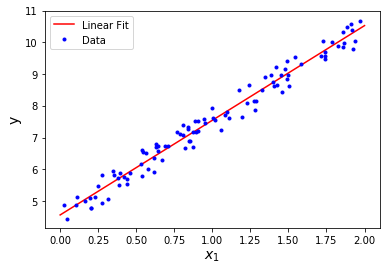

In [4]:
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2,1)), X_new]
y_predict = X_new_b.dot(theta_best)

plt.plot(X_new, y_predict, "r-", label="Linear Fit")
plt.plot(X,y,"b.", label="Data")
plt.xlabel("$x_1$")
plt.ylabel("y")
plt.legend(loc="upper left")
plt.show()

We can do this same linear regression with Scikit-Learn

In [5]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X,y)
lin_reg.intercept_,lin_reg.coef_

(array([4.56162449]), array([[2.98328893]]))

#### Note on Compuational complexity
The Since the Normal equation computes the inverse of $\mathbf{X^{T}X}$, which is an $(n+1)\times(n+1)$ matrix where n is the number of features, the computational complexity of the calcuation is about $O(n^{2.4})$ to $O(n^{3})$ depending on the implementation.

Using Singular Value Decomposition, the compuational complexity of Scikit-Learn's Linear Regression class is about $O(n^{2})$.  So, for large number of features and a linear model, Gradient Descent training will be faster.

## Gradient Descent

The general idea of Gradient Descent is to see how the cost function changes with respect to changes with model parameters and then step in the direction that minimizes the cost function.  The Gradient of the cost function with respect to the model parameters determines in which direction to step.  In equation form, this looks like
\begin{equation}
\mathbf{\theta}^{\text{next step}} = \mathbf{\theta} - \eta \nabla_{\mathbf{\theta}}J(\mathbf{\theta})
\end{equation}
where $\eta$ is the learning rate and determines the magnitude of the step in the direction of negative gradient.

Let's look at a simple implementation of the algorithm using the mean square error as the cost function, i.e. $J(\mathbf{\theta}) = \text{MSE}\mathbf{\theta}$.  This has the gradient
\begin{equation}
\nabla_{\mathbf{\theta}}\text{MSE}(\mathbf{\theta}) = \frac{2}{m} \mathbf{X^{T}}(\mathbf{X\theta - y})
\end{equation}


In [6]:
eta = 0.1 #learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2,1) #random initialization of initial parameters

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients
    
theta

array([[4.56162449],
       [2.98328893]])

We arrive at the same result as the Normal Equation! Let's take a graphical look at how the Gradient Descent algorithm converges

In [7]:
theta_path_bgd = []
def plot_gradient_descent(theta,eta,theta_path_bgd=None):
    m = len(X_b)
    plt.plot(X,y,"b.")
    n_iterations = 500
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path_bgd is not None:
            theta_path_bgd.append(theta)
    plt.xlabel("$x_1$")
    plt.title(r"$\eta = {}$".format(eta),fontsize=16)

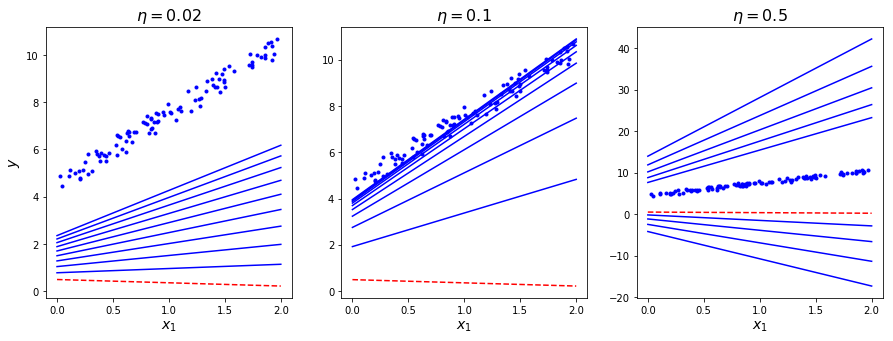

In [8]:
np.random.seed(42)
theta = np.random.randn(2,1)

plt.figure(figsize=(15,5))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$")
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path_bgd = theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)
plt.show()

1. First plot shows a learning rate that is converging, but slowly
2. Second plot has a learning rate that is about right and is converging quickly
3. Third plot has a learning rate so high that the model is actually diverging (note the y-scale change)

Note that this was an example of Batch Gradient Descent because we used every data point to compute the gradient at each step.

#### Stochastic Gradient Descent

Using only one random instance of the data to compute the gradient is called Stochastic Gradient Descent.  Pros: fast and escapes local minima,  Cons: Will never completely diverge at minimum of cost function and is much less regular.

To converge slowly as the cost function decreases, we can create a learning schedule that reduces the learning rate as SGD converges

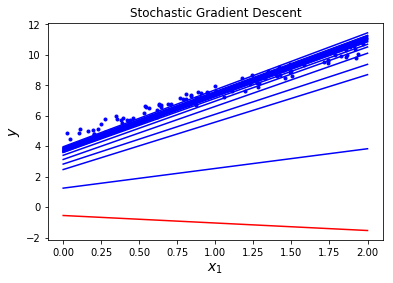

array([[4.54679532],
       [2.97431426]])

In [25]:
n_epochs = 50
t0,t1 = 5,50 # learning schedule hyperparameters

def learning_schedule(t):
    return t0/(t + t1)

theta = np.random.randn(2,1)
theta_path_sgd = []

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:
            y_predict = X_new_b.dot(theta)
            style = "b-" if i > 0 else "r-"
            plt.plot(X_new, y_predict, style)
        random_index = np.random.randint(m) #Selecting random instances of the data
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2* xi.T.dot(xi.dot(theta) - yi) #computing gradients and learning rate
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients #changing parameters
        theta_path_sgd.append(theta)

plt.plot(X,y,"b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$")
plt.title("Stochastic Gradient Descent")
plt.show()
theta

Scikit-Learn has Stochastic Gradient Descent build in:

In [10]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=50,penalty=None,eta0=0.1,random_state=42, tol=1e-3)
sgd_reg.fit(X,y.ravel())

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.1, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=50,
       n_iter=None, n_iter_no_change=5, penalty=None, power_t=0.25,
       random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
       verbose=0, warm_start=False)

In [11]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.5255031]), array([2.99524824]))

### Comparing Batch, Mini-Batch, and Stochastic Gradient Descent

In [12]:
theta_path_mbgd = []

n_iterations = 50
minibatch_size = 20

t0, t1 = 10,1000

theta = np.random.randn(2,1)
t=0

for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0,m,minibatch_size):
        t+=1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mbgd.append(theta)

theta
        
        

array([[4.57326855],
       [2.98594876]])

[3.8, 4.7, 2.5, 4]

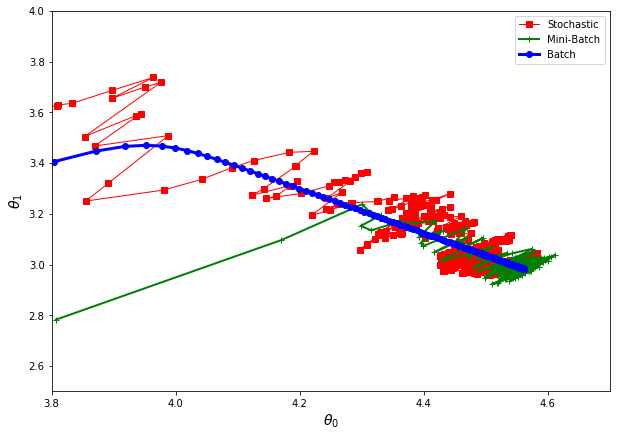

In [27]:
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mbgd = np.array(theta_path_mbgd)
theta_path_bgd = np.array(theta_path_bgd)

plt.figure(figsize=(10,7))
plt.plot(theta_path_sgd[:,0],theta_path_sgd[:,1],"r-s",linewidth=1,label="Stochastic")
plt.plot(theta_path_mbgd[:,0],theta_path_mbgd[:,1],"g-+",linewidth=2,label="Mini-Batch")
plt.plot(theta_path_bgd[:,0],theta_path_bgd[:,1],"b-o",linewidth=3,label="Batch")
plt.legend(loc="upper right")
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")
plt.axis([3.8,4.7,2.5,4])




## Polynomial Regression

We can add powers of features as new features to fit nonlinear data with a linear regressor

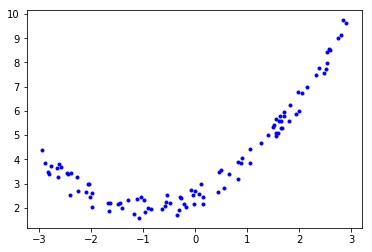

In [30]:
m = 100
X = 6*np.random.rand(m,1) - 3
y = 0.5*X**2 + X + 2 + np.random.rand(m,1)

plt.plot(X,y,"b.")

Trying to fit this data with a linear regressor will obviously not work out very well...

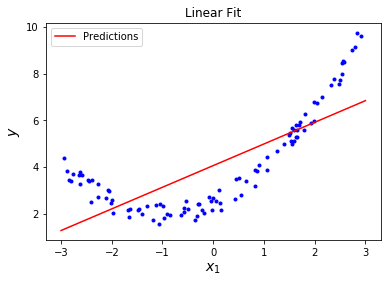

In [38]:
lin_reg.fit(X,y)
X_new = np.linspace(-3,3,100).reshape(100,1)
y_new = lin_reg.predict(X_new)
plt.plot(X,y,"b.")
plt.plot(X_new,y_new,"r-", label="Predictions")
plt.xlabel("$x_1$")
plt.ylabel("$y$")
plt.legend(loc="upper left")
plt.title("Linear Fit")
plt.show()

But, we can be smart. Let's modify the data but still fit with the linear regressor

In [40]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
lin_reg.fit(X_poly,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

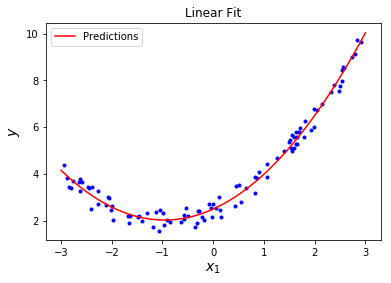

In [42]:
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X,y,"b.")
plt.plot(X_new,y_new,"r-", label="Predictions")
plt.xlabel("$x_1$")
plt.ylabel("$y$")
plt.legend(loc="upper left")
plt.title("Linear Fit")
plt.show()

We can event fit higher order polynomials to this data too

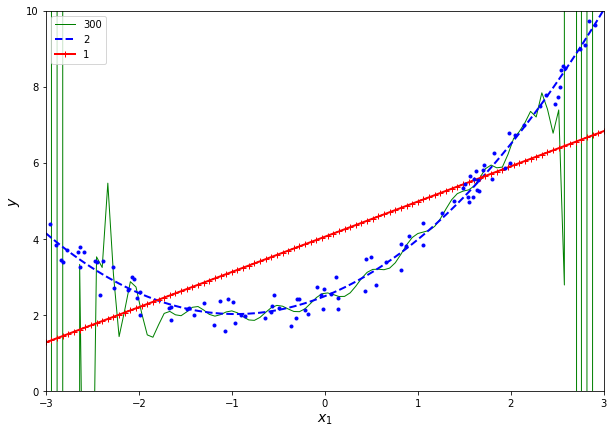

In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

plt.figure(figsize=(10,7))
swd = (("g-",1,300),
      ("b--",2,2),
      ("r-+",2,1))
for style,width,degree in swd:
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    poly_reg_pipeline = Pipeline([
        ("poly_features",polybig_features),
        ("std_scaler",std_scaler),
        ("lin_reg",lin_reg)
    ])
    poly_reg_pipeline.fit(X,y)
    y_newbig = poly_reg_pipeline.predict(X_new)
    plt.plot(X_new,y_newbig,style,label=str(degree),linewidth=width)
    
plt.plot(X,y,"b.")
plt.legend(loc="upper left")
plt.xlabel("$x_1$")
plt.ylabel("$y$")
plt.axis([-3,3,0,10])
plt.show()

## Learning Curves

We can clearly see in the above plot that the very high degree polynomial is overfitting the training data. Besides looking at cross-validation to determine overfitting, let's instead look at learning curves.

In [69]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2)
    train_errors, val_errors = [],[]
    for m in range(1,len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict,y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict,y_val))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="Train")
    plt.plot(np.sqrt(val_errors),"b-",linewidth=2,label="Validation")   

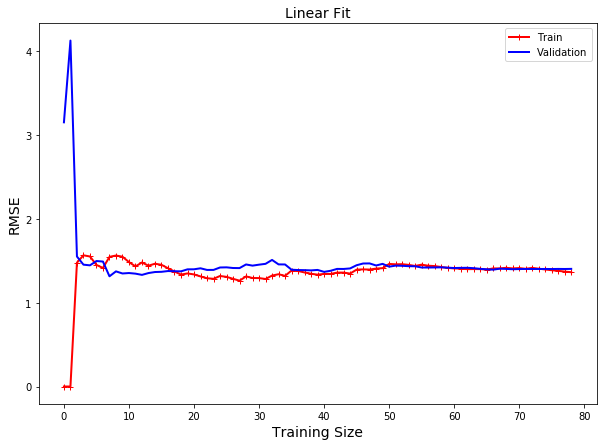

In [80]:
lin_reg = LinearRegression()
plt.figure(figsize=(10,7))
plot_learning_curves(lin_reg,X,y)
plt.xlabel("Training Size")
plt.ylabel("RMSE")
plt.title("Linear Fit",size=14)
plt.legend(loc="upper right")

Both training and validation error have hit plateaus and do not get better with increased data -- likely underfitting the model

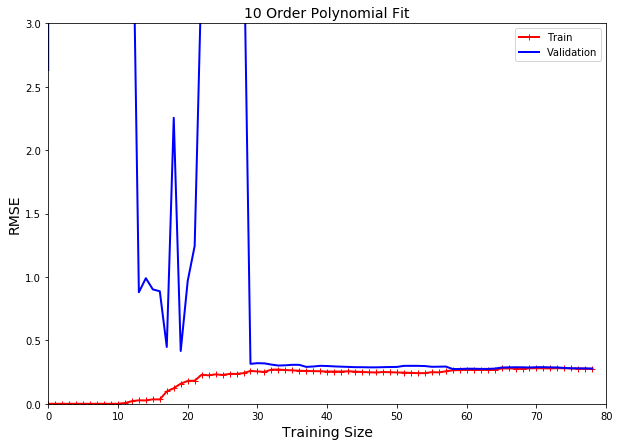

In [87]:
poly_reg_pipeline = Pipeline([
    ("poly_features",PolynomialFeatures(degree=10,include_bias=False)),
    ("lin_reg",LinearRegression()),
])

plt.figure(figsize=(10,7))
plot_learning_curves(poly_reg_pipeline,X,y)
plt.xlabel("Training Size")
plt.ylabel("RMSE")
plt.title("10 Order Polynomial Fit",size=14)
plt.axis([0,80,0,3])
plt.legend(loc="upper right")
plt.show()

Couple of things to note here:
1. Since we have a 10th order polynomial, the model will fit the first 10 points perfectly.  Overfitting to the max!
2. With limited amount of data, this model overfits.  One way to prevent overfitting is to add more training data, which can be seen above
3. Another way to prevent overfitting is to add regularization to the model. 

## Regularized Linear Models

#### Ridge Regression / L2 Regularization 

Adds a term to the cost function to penalize very strong weights being given to parameters:
\begin{equation}
J(\mathbf{\theta}) = \text{MSE}\mathbf{\theta} + \alpha \frac{1}{2} \sum^{n}_{i=1} \theta_{i}^{2}
\end{equation}
where the bias term $\theta_{0}$ is not regularized and $\alpha$ controls the regularization strength.  Note that as $\alpha \rightarrow 0$, the cost function reduces back to simply MSE. 

In [95]:
from sklearn.linear_model import Ridge

np.random.seed(42)
m = 100
X = 3 * np.random.rand(m,1)
y = 1 + .5*X + np.random.randn(m,1)/1.5
X_new = np.linspace(0,3,100).reshape(100,1)

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas,("b-","g--","r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model=Pipeline([
                ("poly_features",PolynomialFeatures(degree=10,include_bias=False)),
                ("std_scaler",StandardScaler()),
                ("regularized_reg",model),
            ])
        model.fit(X,y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new,y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X,y,"b.",linewidth=3)
    plt.legend(loc="upper left")
    plt.xlabel("$x_1$")
    plt.ylabel("y")

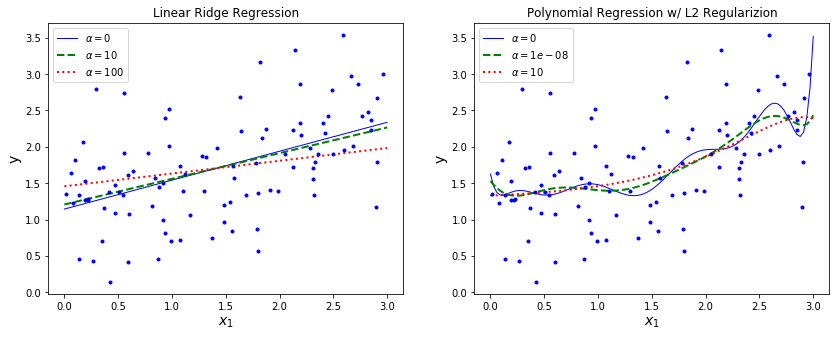

In [106]:
plt.figure(figsize=(14,5))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0,10,100), random_state=42)
plt.title("Linear Ridge Regression")
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0,10**-8,10), random_state=42)
plt.title("Polynomial Regression w/ L2 Regularizion")
plt.show()

#### Lasso Regression / L1 Regularization 

Adds a term to the cost function to eliminate unimportant features:
\begin{equation}
J(\mathbf{\theta}) = \text{MSE}\mathbf{\theta} + \alpha \sum^{n}_{i=1} |{\theta_{i}}|
\end{equation}
where the bias term $\theta_{0}$ is not regularized and $\alpha$ controls the regularization strength.  Note that as $\alpha \rightarrow 0$, the cost function reduces back to simply MSE. 

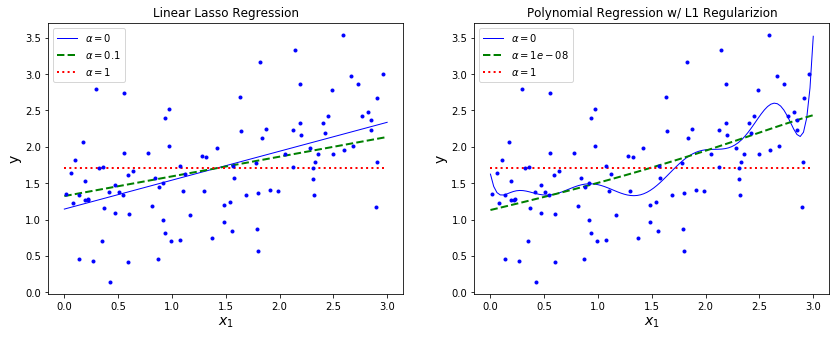

In [109]:
from sklearn.linear_model import Lasso
plt.figure(figsize=(14,5))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0,.1,1), random_state=42)
plt.title("Linear Lasso Regression")
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0,10**-8,1), tol=1, random_state=42)
plt.title("Polynomial Regression w/ L1 Regularizion")
plt.show()

#### Elastic Net

Middle ground between Ridge and Lasso Regression includes both terms in the cost function:
\begin{equation}
J(\mathbf{\theta}) = \text{MSE}\mathbf{\theta} + r\alpha \sum^{n}_{i=1} |{\theta_{i}}| + \alpha \frac{1-r}{2} \sum^{n}_{i=1} \theta_{i}^{2}
\end{equation}
where the $r$ controls the mix between Lasso and Ridge.

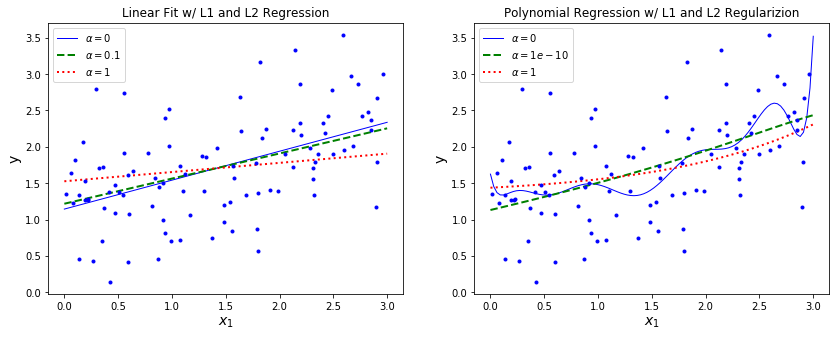

In [115]:
from sklearn.linear_model import ElasticNet
plt.figure(figsize=(14,5))
plt.subplot(121)
plot_model(ElasticNet, polynomial=False, alphas=(0,.1,1), l1_ratio=0.1,random_state=42)
plt.title("Linear Fit w/ L1 and L2 Regression")
plt.subplot(122)
plot_model(ElasticNet, polynomial=True, alphas=(0,10**-10,1),tol =1, l1_ratio=0.1, random_state=42)
plt.title("Polynomial Regression w/ L1 and L2 Regularizion")
plt.show()

#### Early Stopping

When training with an iterative learning algorithm such as Gradient Descent, one way to regularize is to just stop training early when the model performs best on the validation data.

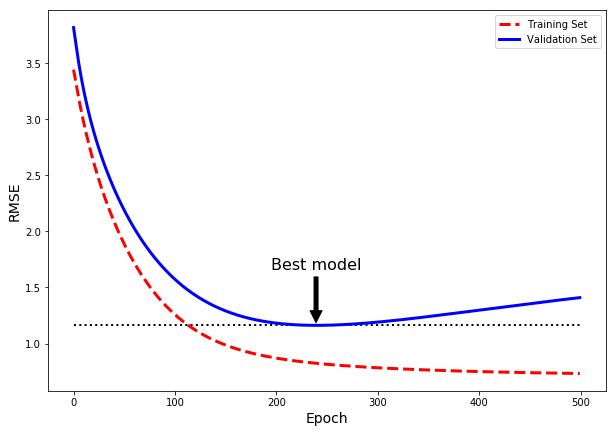

In [184]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m,1) - 3
y = 2 + X + 0.5*X**2 + np.random.randn(m,1)
X_new = np.linspace(0,3,100).reshape(100,1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

poly_scaler_pipeline = Pipeline([
    ("poly_features", PolynomialFeatures(degree=90,include_bias=False)),
    ("std_scaler",StandardScaler()),
])
X_train_poly_scaled = poly_scaler_pipeline.fit_transform(X_train)
X_val_poly_scaled = poly_scaler_pipeline.transform(X_val)


sgd_reg = SGDRegressor(n_iter=1,penalty=None,eta0=.0005, warm_start=True,learning_rate="constant", random_state=42)
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)
warnings.simplefilter(action='ignore',category=DeprecationWarning)

n_epochs=500

train_errors, val_errors = [],[]
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train_predict,y_train))
    val_errors.append(mean_squared_error(y_val_predict,y_val))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.figure(figsize=(10,7))
plt.plot([0,n_epochs],[best_val_rmse, best_val_rmse],"k:", linewidth=2)
plt.plot(np.sqrt(train_errors),"r--",linewidth=3, label="Training Set")
plt.plot(np.sqrt(val_errors),"b-",linewidth=3, label="Validation Set")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend(loc="upper right")
plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + .5),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )
plt.show()
    

Implementing Early Stopping for SGD:

In [186]:
from sklearn.base import clone

poly_scaler = Pipeline([
    ("poly_features",PolynomialFeatures(degree=90, include_bias=False)),
    ("std_scaler",StandardScaler()),
])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True, penalty=None, learning_rate="constant",eta0=.0005)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)
        
best_model

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.0005, fit_intercept=True, l1_ratio=0.15,
       learning_rate='constant', loss='squared_loss', max_iter=1,
       n_iter=None, n_iter_no_change=5, penalty=None, power_t=0.25,
       random_state=None, shuffle=True, tol=-inf, validation_fraction=0.1,
       verbose=0, warm_start=True)

## Logistic Regression

Logistic Regression is a common model used to estimate the probability a given instance belongs to a particular class.  The model is given by 
\begin{equation}
\hat{p} = h_{\theta}(\mathbf{x}) = \sigma (\mathbf{\theta^{T} x})
\end{equation}
where $\sigma$ is the logistic and is a sigmoid function
\begin{equation}
\sigma(t) = \frac{1}{1 + e^{-t}}
\end{equation}
which restricts output to be between 0 and 1 to correspond with a normalized probability range.

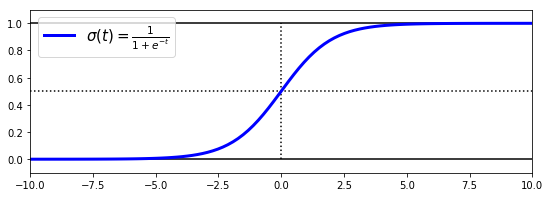

In [202]:
t = np.linspace(-10,10,100)
sig = 1/ (1 + np.exp(-t))
plt.figure(figsize=(9,3))
plt.plot([-10,10],[0,0],"k-")
plt.plot([-10,10],[1,1],"k-")
plt.plot([0,0],[0,1],"k:")
plt.plot([-10,10],[.5,.5],"k:")
plt.plot(t,sig,"b-",linewidth=3,label=r"$\sigma(t) = \frac{1}{1+e^{-t}}$")
plt.axis([-10,10,-.1,1.1])
plt.legend(loc="upper left", fontsize=15)
plt.show()


The logistic regression cost function for a single training instance is given by
\begin{equation}
c(\mathbf{\theta}) = 
    \begin{cases}
        -log(\hat{p}) & \text{if} y = 1 \\
        -log(1-\hat{p}) & \text{if} y = 0
    \end{cases}
\end{equation}
which will generalize to the commonly used log loss cost function for all training instances
\begin{equation}
\mathbf{J(\theta)} = -\frac{1}{m} \sum_{i=1}^{m} \left( y^{(i)} log(\hat{p}^{(i)}) + (1-y^{(i)}) log(1-\hat{p}^{(i)}) \right)
\end{equation}

### Applying Logistic Regression to Scikit-Learn's Iris dataset
Can we build a classifier to detect the Iris-Virginica type based only on petal width?

In [203]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename']

In [221]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [208]:
X = iris["data"][:,3:] #petal width
y = (iris["target"] == 2).astype(np.int) # 1 if Iris-Virginica, else 0

In [218]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

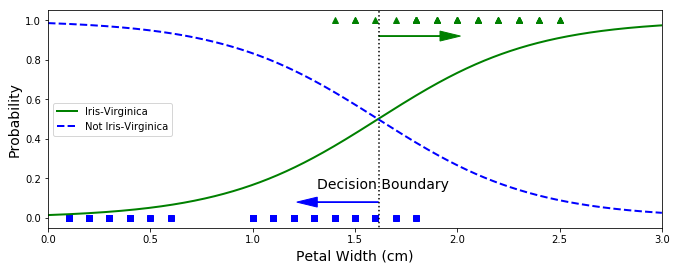

In [236]:
X_new = np.linspace(0,3,1000).reshape(-1,1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:,1] >= 0.5][0]

plt.figure(figsize=(11,4))
plt.plot(X[y==0],y[y==0],"bs")
plt.plot(X[y==1],y[y==1],"g^")
plt.plot([decision_boundary,decision_boundary],[-1,2],"k:")
plt.plot(X_new,y_proba[:,1],"g-",linewidth=2,label="Iris-Virginica")
plt.plot(X_new,y_proba[:,0],"b--",linewidth=2,label="Not Iris-Virginica")
plt.text(decision_boundary+.02,.15,"Decision Boundary", fontsize=14, color="k",ha="center")
plt.arrow(decision_boundary,.08,-0.3,0,head_width=.05, head_length=0.1, fc="b",ec="b")
plt.arrow(decision_boundary,.92,0.3,0,head_width=.05, head_length=0.1, fc="g",ec="g")
plt.axis([0,3,-0.05,1.05])
plt.legend(loc="center left")
plt.ylabel("Probability")
plt.xlabel("Petal Width (cm)")
plt.show()


In [244]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

y_predict = log_reg.predict(X)

print("Accuracy: ", accuracy_score(y_predict,y))
print("Precision: ", precision_score(y_predict,y))
print("Recall: ", round(recall_score(y_predict,y),2))

Accuracy:  0.96
Precision:  0.92
Recall:  0.96


Let's see if we can do better by adding Petal Length

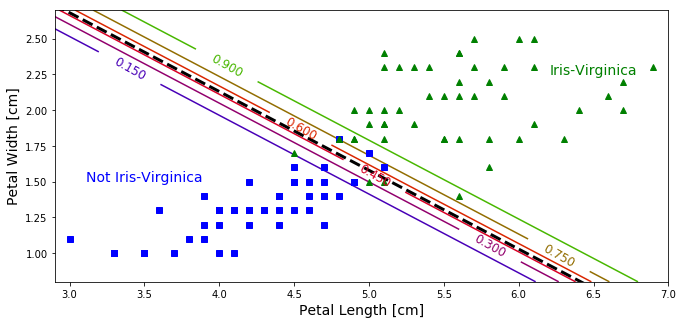

In [253]:
X = iris["data"][:,(2,3)] #petal length, petal width
y = (iris["target"] == 2).astype(np.int)

log_reg = LogisticRegression(C=10**10, random_state=42)
log_reg.fit(X,y)

x0,x1 = np.meshgrid(
    np.linspace(2.9,7,500).reshape(-1,1),
    np.linspace(0.8,2.7,200).reshape(-1,1)
)

X_new = np.c_[x0.ravel(),x1.ravel()]
y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(11,5))
plt.plot(X[y==0,0],X[y==0,1],"bs")
plt.plot(X[y==1,0],X[y==1,1],"g^")

zz = y_proba[:,1].reshape(x0.shape)
contour=plt.contour(x0,x1,zz,cmap="brg")

left_right=np.array([2.9,7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline = 1, fontsize=12)
plt.plot(left_right, boundary,"k--", linewidth= 3)
plt.text(3.5,1.5,"Not Iris-Virginica", fontsize=14, color="b", ha="center")
plt.text(6.5,2.25,"Iris-Virginica", fontsize=14, color="g", ha="center")
plt.axis([2.9,7,0.8,2.7])
plt.xlabel("Petal Length [cm]")
plt.ylabel("Petal Width [cm]")
plt.show()


In [254]:
y_predict = log_reg.predict(X)

print("Accuracy: ", accuracy_score(y_predict,y))
print("Precision: ", precision_score(y_predict,y))
print("Recall: ", round(recall_score(y_predict,y),2))

Accuracy:  0.96
Precision:  0.94
Recall:  0.94


Results are pretty much the same, just the decision boundary shifted slightly to produce more precision, but less recall

## Softmax Regression

Softmax Regression generalizes Logistic Regression to multiple classes without having to train multiple binary models.  This is done by first computing a score $s_{k}(\mathbf{x})$ for each class $k$ given by
\begin{equation}
s_{k}(\mathbf{x}) = (\mathbf{\sigma}^{(k)})^{T}\mathbf{x}
\end{equation}
and then applying the softmax function to compute the probabilities
\begin{equation}
\hat{p}_{k} = \sigma (\mathbf{s}(\mathbf{x}))_{k} = \frac{exp(s_{k}(\mathbf{x}))}{\sum_{j=1}^{K} exp(s_{j}(\mathbf{x}))}
\end{equation}
where $K$ is the number of classes, $\mathbf{s(k)}$ is a vector containing scores of each class for instance $\mathbf{x}$ and $\sigma (\mathbf{s}(\mathbf{x}))_{k}$ is the probability that the instance $\mathbf{x}$ belongs to class $k$ given the scores of each class for that instance.


Training the Softmax Regression model typically involved minimizing the cross entropy cost function given by 
\begin{equation}
J(\Theta) = -\frac{1}{m} \sum_{i=1}^{m} \sum{k=1}{K} y_{k}^{(i)} log(\hat{p}_{k}^{(i)})
\end{equation}
where $y_{k}^(i)$ is the target probability that the ith instance belongs to class $k$. Notice that when $K = 2$, this cross entropy cost function reduces to the log loss cost function used by logistic regression.

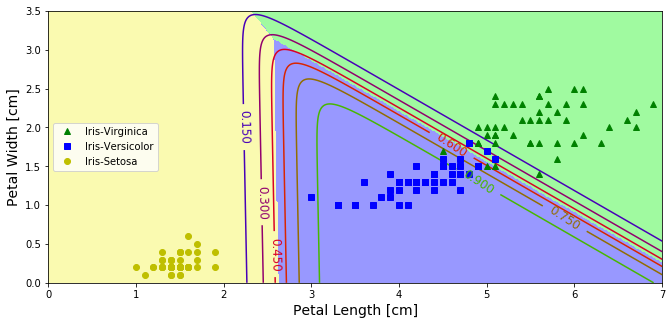

In [262]:
X = iris["data"][:,(2,3)] # petal width, petal length
y = iris["target"]
softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10)
softmax_reg.fit(X,y)

x0, x1 = np.meshgrid(
    np.linspace(0,8,500).reshape(-1,1),
    np.linspace(0,3.5,200).reshape(-1,1)
)

X_new = np.c_[x0.ravel(),x1.ravel()]

y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:,1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(11,5))
plt.plot(X[y==2,0], X[y==2,1],"g^", label="Iris-Virginica")
plt.plot(X[y==1,0], X[y==1,1],"bs", label="Iris-Versicolor")
plt.plot(X[y==0,0], X[y==0,1],"yo", label="Iris-Setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0,x1,zz,cmap=custom_cmap)
contour = plt.contour(x0,x1,zz1,cmap="brg")
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal Length [cm]")
plt.ylabel("Petal Width [cm]")
plt.legend(loc="center left")
plt.axis([0,7,0,3.5])
plt.show()

In [263]:
y_predict = softmax_reg.predict(X)
print("Accuracy: ", accuracy_score(y_predict,y))

Accuracy:  0.96


## What have we accomplished?

1. How to find linear regression parameters that minimize the Mean Squared Error cost function by directly computing them with via Normal Equation.
2. Converge on a solution for linear regression using Batch, Mini-Batch, and Stochastic Gradient Descent by minimizing the Mean Squared Error cost function.
3. Looked at how to insert non-linearity into the linear regression by adding powers of features, i.e. polynomial regression.
4. Plotted learning curves for gradient descent.
5. Explored Lasso (L1), Ridge (L2), and Elastic Net (L1 + L2) regularization of linear regression as well as how early stopping can also prevent overfitting.
6. Transformed linear regression to logistic regression by applying the sigmoid function to predctions and using the log loss cost function to estimate probabilites of instances belonging to certian classes.
7. Applied the softmax function instead of the sigmoid function to create Softmax Regression used to classify 